In [7]:
import numpy as np
import pandas as pd
from itertools import *
from pulp import *
import riskfolio as rp 
import warnings 
import datetime as datetime
import yfinance as yf
from bs4 import BeautifulSoup
import requests
from pulp import *
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import Markdown as md
%matplotlib widget


# Part 1

In [8]:
'''Table from the prompt'''
data_prompt = pd.read_excel('Table.xlsx', sheet_name='PromptUse', index_col = 'DateDue')

'''
For some reason BeautifulSoup did not want to work so I just downloaded the table from  a link into an excel 
https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202205
For the term structure
'''

yields = pd.read_html('https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202205')[0]

In [9]:
term_structure_df = pd.read_excel('Table.xlsx', sheet_name='Bills Bonds and Notes', index_col='MATURITY')
term_structure_df

,COUPON,BID,ASKED,CHG,ASKED YIELD
MATURITY,,,,,
2022-05-05,0.000,0.068,0.058,0.025,0.0580
2022-05-10,0.000,0.085,0.075,-0.018,0.0760
2022-05-12,0.000,0.153,0.143,0.005,0.1450
2022-05-15,1.750,100.020,100.024,-0.004,-0.6005
2022-05-15,2.125,100.024,100.030,-0.002,-0.6944
...,...,...,...,...,...
2051-02-15,1.875,76.260,76.280,-2.006,3.0940
2051-05-15,2.375,86.102,86.122,-2.058,3.0890
2051-08-15,2.000,79.056,79.076,-2.016,3.0810


In [10]:
data_prompt

,Amount
DateDue,
2022-12-15,11000
2023-06-15,9000
2023-12-15,8000
2024-06-15,7000
2024-12-15,9000
2025-06-15,10000
2025-12-15,9000
2026-06-15,12000
2026-12-15,9000


In [11]:
pd.merge(
    left=data_prompt,
    right=term_structure_df,
    how='left',
    left_index=True,
    right_index=True
)

,Amount,COUPON,BID,ASKED,CHG,ASKED YIELD
2022-12-15,11000,1.625,100.000,100.004,-0.004,1.599
2023-06-15,9000,0.250,97.256,97.262,-0.018,2.235
2023-12-15,8000,0.125,96.030,96.034,-0.02,2.596
2024-06-15,7000,0.250,94.260,94.264,-0.03,2.781
2024-12-15,9000,1.000,95.074,95.080,-0.05,2.894
2025-06-15,10000,NaN,NaN,NaN,NaN,NaN
2025-12-15,9000,NaN,NaN,NaN,NaN,NaN
2026-06-15,12000,NaN,NaN,NaN,NaN,NaN
2026-12-15,9000,NaN,NaN,NaN,NaN,NaN
2027-06-15,6000,NaN,NaN,NaN,NaN,NaN


In [12]:
yields = yields.drop(columns=yields.columns.to_list()[0:8])/100

In [13]:
yields.columns = [int(i.replace('Yr', '')) 
if i[2:4] == 'Yr' or i[3:5] == 'Yr' else int(i.replace('Mo', ''))/12 
for i in yields.columns.to_list()]

## Current Term Structure/Yield Curve

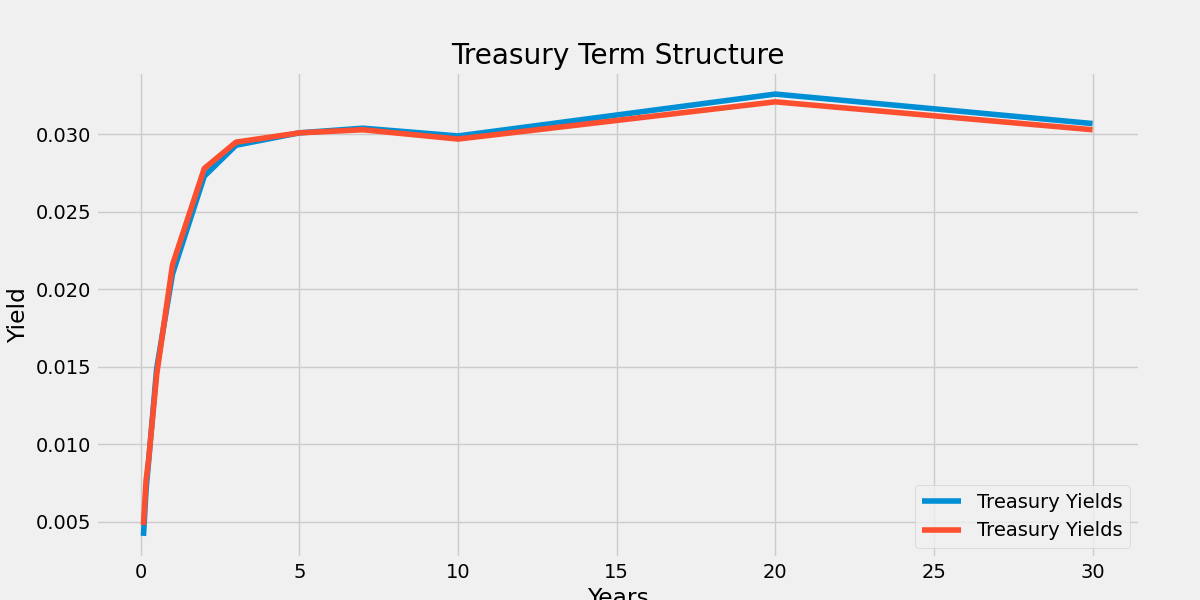

In [14]:
with plt.style.context('fivethirtyeight'):
    fig = plt.subplots(figsize=(12,6))
    plt.plot(yields.T, label = 'Treasury Yields')
    plt.title('Treasury Term Structure')
    plt.ylabel('Yield')
    plt.xlabel('Years')
    plt.legend()

## PV, Duration, Convexity

### PV

In [15]:
data_prompt

,Amount
DateDue,
2022-12-15,11000
2023-06-15,9000
2023-12-15,8000
2024-06-15,7000
2024-12-15,9000
2025-06-15,10000
2025-12-15,9000
2026-06-15,12000
2026-12-15,9000


In [16]:
'''
I am just getting the year fractions for both liabilties and the maturities of the on-the-run treasuries (term structure).

I had to manually get alot of this so data probably is not correct but the methodology should be sound.
'''
# Fractional year in days of liabilties due
liabilities_dates_as_yr_frac = [
    (datetime.date(int(i[0:4]),int(i[5:7]),int(i[8:10])) - datetime.date.today()).days/365
    for i in [str(i)[0:10] for i in data_prompt.index.tolist()]
]
# Maturity dates for term structure that will be applicable aka (1-10yr term rates)
actual_rates_maturities = [
    datetime.date(2023, 4, 20),
    datetime.date(2024, 4, 30),
    datetime.date(2025, 4, 15),
    datetime.date(2027, 4, 30),
    datetime.date(2029, 4, 30),
    datetime.date(2032, 2, 15)
]
# Fractional year in days of term structure
actual_rates_yr_frac = [(i - datetime.date.today()).days/365 for i in actual_rates_maturities]


In [17]:
'''Converting data types'''

actual_rates = yields.values.tolist()[0][4:10]
liabilities = data_prompt['Amount'].tolist()

In [18]:
'''
I am creating a list to match the maturities of the liabilities with their corresponding rate within the term structure.

Logic:

Append the list of term rates who's fractional year is >= the fractional year of the liability in question. 
Take the first value in that list as the corresponding risk free rate to discount for that period. 
'''
rates_for_periods = [
    [actual_rates[i] for i in range(0,len(actual_rates)) if liabilities_dates_as_yr_frac[t] <=  actual_rates_yr_frac[i]][0]
    for t in range(0, len(liabilities))
    ]

In [19]:
rates_for_periods

[0.021,
 0.0273,
 0.0273,
 0.029300000000000003,
 0.029300000000000003,
 0.0301,
 0.0301,
 0.0301,
 0.0301,
 0.0304,
 0.0304,
 0.0304,
 0.0304,
 0.029900000000000003,
 0.029900000000000003,
 0.029900000000000003]

In [20]:
'''
Periods for the liabilities aka 
12/15/2022 is 1
6/15/2023 is 1.5
etc.

Cannot use a step value of 1 like in HW 2
'''
periods = [i/2 for i in range(1,18)][1:]

In [21]:
'''Discounting factors for npv, duration, and convexity'''
npv_dis_fac = [1/((1+rates_for_periods[i])**(periods[i])) for i in range(0,len(rates_for_periods))] 
dur_dis_fac = [(periods[i])/((1+rates_for_periods[i])**(periods[i])) for i in range(0,len(rates_for_periods))] 
conv_dis_fac = [((periods[i])*(periods[i]+1))/((1+rates_for_periods[i])**(periods[i]+2)) for i in range(0,len(rates_for_periods))] 

'''Npv, duration, and convexity of liabilities'''
npv = sum([npv_dis_fac[i] * liabilities[i] for i in range(0,len(rates_for_periods))])
duration = sum([dur_dis_fac[i] * liabilities[i] for i in range(0,len(rates_for_periods))])/npv
convexity = sum([conv_dis_fac[i] * liabilities[i] for i in range(0,len(rates_for_periods))])/npv

In [22]:
npv

116739.2966512272

In [23]:
duration

4.3693912392758305

In [24]:
convexity

27.049901651011396

In [25]:
'''Going to make the output look nice in this cell'''

'Going to make the output look nice in this cell'

# Part 2/3

Note: Most of this is part 3 but the beginnning is Part two on how decide what bonds to solve for

## Setting up the Solver (Mostly Part 2)

In [26]:
'''
I used WSJ for the Bonds, Note, and Bills Options and I importing it now
It is sorted by maturity 
URL is https://www.wsj.com/market-data/bonds/treasuries?mod=md_bond_view_treasury_quotes

You cannot webscrape it or do not want to go through the hassle of figuring it out and wanted something rough 
so just copied and pasted into the excel file for both sections on the page and then rearanged it for ease of use
for Dataframe
'''

'''This part will be working on generating the Cashflow matrix that will be needed for the solver'''


# The dataframe of the bonds I explained earlier
possible_bonds = pd.read_excel('Table.xlsx', sheet_name='Bills Bonds and Notes', index_col = 'MATURITY')


In [27]:
possible_bonds

,COUPON,BID,ASKED,CHG,ASKED YIELD
MATURITY,,,,,
2022-05-05,0.000,0.068,0.058,0.025,0.0580
2022-05-10,0.000,0.085,0.075,-0.018,0.0760
2022-05-12,0.000,0.153,0.143,0.005,0.1450
2022-05-15,1.750,100.020,100.024,-0.004,-0.6005
2022-05-15,2.125,100.024,100.030,-0.002,-0.6944
...,...,...,...,...,...
2051-02-15,1.875,76.260,76.280,-2.006,3.0940
2051-05-15,2.375,86.102,86.122,-2.058,3.0890
2051-08-15,2.000,79.056,79.076,-2.016,3.0810


In [28]:
'''Chopping off the maturities that are too far away'''

possibilities = possible_bonds.drop(index=[i for i in possible_bonds.index.to_list() if i > data_prompt.index.to_list()[-1]])

## Where Part 3 Really Starts

In [29]:
'''Prices Vector: I am just using the ASKED value to be able to get down to Building out CFs function'''

prices = [i if i>=5 else 100 - i for i in possibilities['ASKED'].to_list()]


In [30]:
'''List of bond maturities less than liability maturity'''
date_lists_to_change_to_periods = [
    [i for i in possibilities.index.to_list() if i <= t]
    for t in data_prompt.index.tolist()
    ]
'''Removing the duplicates from each one'''
for i in reversed(range(1,len(date_lists_to_change_to_periods))):
    for j in range(0,len(date_lists_to_change_to_periods[i-1])):
        date_lists_to_change_to_periods[i].remove(date_lists_to_change_to_periods[i-1][j])



In [31]:
possibilities_periods = pd.DataFrame(index = possibilities.index, columns=['period','bond#','coupon','face'])

In [32]:
possibilities_periods

,period,bond#,coupon,face
MATURITY,,,,
2022-05-05,NaN,NaN,NaN,NaN
2022-05-10,NaN,NaN,NaN,NaN
2022-05-12,NaN,NaN,NaN,NaN
2022-05-15,NaN,NaN,NaN,NaN
2022-05-15,NaN,NaN,NaN,NaN
...,...,...,...,...
2029-08-15,NaN,NaN,NaN,NaN
2029-11-15,NaN,NaN,NaN,NaN
2030-02-15,NaN,NaN,NaN,NaN


In [33]:
for i in range(0,len(date_lists_to_change_to_periods)):
    possibilities_periods.loc[date_lists_to_change_to_periods[i],'period'] = i+1

possibilities_periods['bond#'] = range(1,len(possibilities_periods)+1)
possibilities_periods['coupon'] = possibilities['COUPON']
possibilities_periods['face'] = 100
possibilities_periods = possibilities_periods.set_index('bond#')

In [34]:
possibilities_periods

,period,coupon,face
bond#,,,
1,1,0.000,100
2,1,0.000,100
3,1,0.000,100
4,1,1.750,100
5,1,2.125,100
...,...,...,...
283,15,6.125,100
284,15,1.750,100
285,16,1.500,100


In [35]:
cfs = np.zeros((len(possibilities_periods),len(date_lists_to_change_to_periods)))

In [36]:
'''CF Matrix'''
'''Will make function later'''
for i in range(0, len(cfs)):

    # Period 1 Bonds
    if possibilities_periods.loc[i+1,'period'] == 1 and possibilities_periods.loc[i+1,'coupon'] == 0:
        cfs[i][0] = possibilities_periods.loc[i+1,'face']
    elif possibilities_periods.loc[i+1,'period'] == 1 and possibilities_periods.loc[i+1,'coupon'] != 0:
        cfs[i][0] = possibilities_periods.loc[i+1,'face'] + possibilities_periods.loc[i+1,'coupon']/2
        
    # Period 2 Bonds
    elif possibilities_periods.loc[i+1,'period'] == 2 and possibilities_periods.loc[i+1,'coupon'] == 0:
        cfs[i][1] = possibilities_periods.loc[i+1,'face']
    elif possibilities_periods.loc[i+1,'period'] == 2 and possibilities_periods.loc[i+1,'coupon'] != 0:
        cfs[i][0] = possibilities_periods.loc[i+1,'coupon']/2
        cfs[i][1] = possibilities_periods.loc[i+1,'face'] + possibilities_periods.loc[i+1,'coupon']/2
    
    # Period 3 Bonds (No more T-Bills)
    elif possibilities_periods.loc[i+1,'period'] == 3:
        cfs[i][0:2] = possibilities_periods.loc[i+1,'coupon']/2
        cfs[i][2] = possibilities_periods.loc[i+1,'face'] + possibilities_periods.loc[i+1,'coupon']/2
    # Period 4 Bonds 
    elif possibilities_periods.loc[i+1,'period'] == 4:
        cfs[i][0:3] = possibilities_periods.loc[i+1,'coupon']/2
        cfs[i][3] = possibilities_periods.loc[i+1,'face'] + possibilities_periods.loc[i+1,'coupon']/2

    # Period 5 Bonds
    elif possibilities_periods.loc[i+1,'period'] == 5:
        cfs[i][0:4] = possibilities_periods.loc[i+1,'coupon']/2
        cfs[i][4] = possibilities_periods.loc[i+1,'face'] + possibilities_periods.loc[i+1,'coupon']/2
    # Period 6 Bonds 
    elif possibilities_periods.loc[i+1,'period'] == 6:
        cfs[i][0:5] = possibilities_periods.loc[i+1,'coupon']/2
        cfs[i][5] = possibilities_periods.loc[i+1,'face'] + possibilities_periods.loc[i+1,'coupon']/2

    # Period 7 Bonds
    elif possibilities_periods.loc[i+1,'period'] == 7:
        cfs[i][0:6] = possibilities_periods.loc[i+1,'coupon']/2
        cfs[i][6] = possibilities_periods.loc[i+1,'face'] + possibilities_periods.loc[i+1,'coupon']/2
    # Period 8 Bonds 
    elif possibilities_periods.loc[i+1,'period'] == 8:
        cfs[i][0:7] = possibilities_periods.loc[i+1,'coupon']/2
        cfs[i][7] = possibilities_periods.loc[i+1,'face'] + possibilities_periods.loc[i+1,'coupon']/2    
    
    # Period 9 Bonds
    elif possibilities_periods.loc[i+1,'period'] == 9:
        cfs[i][0:8] = possibilities_periods.loc[i+1,'coupon']/2
        cfs[i][8] = possibilities_periods.loc[i+1,'face'] + possibilities_periods.loc[i+1,'coupon']/2
    # Period 10 Bonds 
    elif possibilities_periods.loc[i+1,'period'] == 10:
        cfs[i][0:9] = possibilities_periods.loc[i+1,'coupon']/2
        cfs[i][9] = possibilities_periods.loc[i+1,'face'] + possibilities_periods.loc[i+1,'coupon']/2
    # Period 11 Bonds
    elif possibilities_periods.loc[i+1,'period'] == 11:
        cfs[i][0:10] = possibilities_periods.loc[i+1,'coupon']/2
        cfs[i][10] = possibilities_periods.loc[i+1,'face'] + possibilities_periods.loc[i+1,'coupon']/2
    # Period 12 Bonds 
    elif possibilities_periods.loc[i+1,'period'] == 12:
        cfs[i][0:11] = possibilities_periods.loc[i+1,'coupon']/2
        cfs[i][11] = possibilities_periods.loc[i+1,'face'] + possibilities_periods.loc[i+1,'coupon']/2
    # Period 13 Bonds
    elif possibilities_periods.loc[i+1,'period'] == 13:
        cfs[i][0:12] = possibilities_periods.loc[i+1,'coupon']/2
        cfs[i][12] = possibilities_periods.loc[i+1,'face'] + possibilities_periods.loc[i+1,'coupon']/2
    # Period 14 Bonds 
    elif possibilities_periods.loc[i+1,'period'] == 14:
        cfs[i][0:13] = possibilities_periods.loc[i+1,'coupon']/2
        cfs[i][13] = possibilities_periods.loc[i+1,'face'] + possibilities_periods.loc[i+1,'coupon']/2
    # Period 15 Bonds
    elif possibilities_periods.loc[i+1,'period'] == 15:
        cfs[i][0:14] = possibilities_periods.loc[i+1,'coupon']/2
        cfs[i][14] = possibilities_periods.loc[i+1,'face'] + possibilities_periods.loc[i+1,'coupon']/2
    # Period 16 Bonds 
    elif possibilities_periods.loc[i+1,'period'] == 16:
        cfs[i][0:15] = possibilities_periods.loc[i+1,'coupon']/2
        cfs[i][15] = possibilities_periods.loc[i+1,'face'] + possibilities_periods.loc[i+1,'coupon']/2

In [37]:
'''Changing the CF matrix to a List of Lists just to be safe as PuLP may not use numpy arrays'''

cf_matrix = cfs.tolist()

In [38]:
'''Solving for the dedicated portfolio'''
'''PuLP time Bitches I am ripping from my answer in HW2 Prob 3a'''
# Making variable list of strings
bonds = ['$b_{}$'.format('{'+str(i)+'}') for i in range(1, len(cf_matrix)+1)]
periods = [i for i in range(0,len(cf_matrix[0])+1)]
# Must reverse both price vector and cashflow matrix
cf_matrix.reverse()
prices.reverse()

# Dictionary of period constraints
period_dict = {}
for i in range(0,len(cf_matrix[0])):
    period_dict['Period {}'.format(i+1)] = dict(zip(bonds,[cf_matrix[j][i] for j in range(0,len(cf_matrix))]))

objective = dict(zip(bonds, prices))
# Decision Vars
quantity = LpVariable.dict('', bonds, lowBound=0)
excess = LpVariable.dict('carryover', periods, lowBound=0)
# Intializing the Problem
dedication_1 = LpProblem('Dedicated', LpMinimize)
# Objective function
dedication_1 += excess[0]+lpSum([objective[i]*quantity[i] for i in bonds])
# Constraints
for i in range(0,len(cf_matrix[0])-1):
    dedication_1 += lpSum([period_dict['Period {}'.format(i+1)][j]*quantity[j] for j in bonds]) + excess[i]- excess[i+1] == liabilities[i]

dedication_1.solve()


1

In [39]:
solutions_1 = [v.varValue for v in dedication_1.variables()][0:len(bonds)]
solution_df_1 = pd.DataFrame(solutions_1,index=bonds,columns= ['Quantity'])

cost_each_1 = [solutions_1[i]*prices[i] for i in range(0,len(bonds))]
val_1 = sum(cost_each_1)

In [40]:
solution_df_1.drop(index = [i for i in bonds if solution_df_1.loc[i,'Quantity'] == 0], inplace=True)

In [41]:
'''Printing Solutions'''

md(''' 
##### <center> Dedication Portfolio Cost & Composition  </center>

<center>

Portfolio Cost $ = \${:.2f} $ <br>

</center>

<center>

{}

'''.format(val_1,solution_df_1.to_markdown(colalign = ("right",))))

 
##### <center> Dedication Portfolio Cost & Composition  </center>

<center>

Portfolio Cost $ = \$105900.55 $ <br>

</center>

<center>

|           |   Quantity |
|----------:|-----------:|
|  $b_{13}$ |    81.3914 |
|  $b_{27}$ |    71.1246 |
|  $b_{45}$ |    51.0608 |
|  $b_{87}$ |    59.2105 |
|  $b_{98}$ |    69.1241 |
| $b_{122}$ |    86.1716 |
| $b_{165}$ |    86.0064 |
| $b_{177}$ |    65.2339 |
| $b_{215}$ |    44.7306 |
| $b_{231}$ |    52.9758 |
| $b_{248}$ |    80.2668 |
| $b_{254}$ |    79.3552 |
| $b_{264}$ |   107.055  |
| $b_{265}$ |    68.5413 |
| $b_{281}$ |    74.4944 |



In [46]:
np.array(cf_matrix)

array([[  3.125 ,   3.125 ,   3.125 , ...,   3.125 ,   3.125 , 103.125 ],
       [  0.3125,   0.3125,   0.3125, ...,   0.3125,   0.3125, 100.3125],
       [  0.75  ,   0.75  ,   0.75  , ...,   0.75  ,   0.75  , 100.75  ],
       ...,
       [100.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ],
       [100.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ],
       [100.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ]])

In [42]:
npv

116739.2966512272

Possibily going wrong somewhere but do not know where. It is late. Should optimla cost be this far off from the NPV?

# Part 4

In [43]:
rates_for_periods[0:15]

[0.021,
 0.0273,
 0.0273,
 0.029300000000000003,
 0.029300000000000003,
 0.0301,
 0.0301,
 0.0301,
 0.0301,
 0.0304,
 0.0304,
 0.0304,
 0.0304,
 0.029900000000000003,
 0.029900000000000003]

 
##### <center> Sensitivity & Rates </center>

<center>

|   Period |   shadow price |   implied rates |   actual rates |
|---------:|---------------:|----------------:|---------------:|
|        1 |       0.977023 |       0.0235174 |         0.021  |
|        2 |       0.970186 |       0.0203833 |         0.0273 |
|        3 |       0.95231  |       0.0247332 |         0.0273 |
|        4 |       0.937843 |       0.0260012 |         0.0293 |
|        5 |       0.924583 |       0.0264822 |         0.0293 |
|        6 |       0.906067 |       0.0285843 |         0.0301 |
|        7 |       0.895403 |       0.0280054 |         0.0301 |
|        8 |       0.879163 |       0.0290324 |         0.0301 |
|        9 |       0.862658 |       0.0299882 |         0.0301 |
|       10 |       0.849548 |       0.0300895 |         0.0304 |
|       11 |       0.840671 |       0.0293482 |         0.0304 |
|       12 |       0.827461 |       0.0295662 |         0.0304 |
|       13 |       0.812954 |       0.030025  |         0.0304 |
|       14 |       0.804787 |       0.0293803 |         0.0299 |
|       15 |       0.795397 |       0.0290275 |         0.0299 |



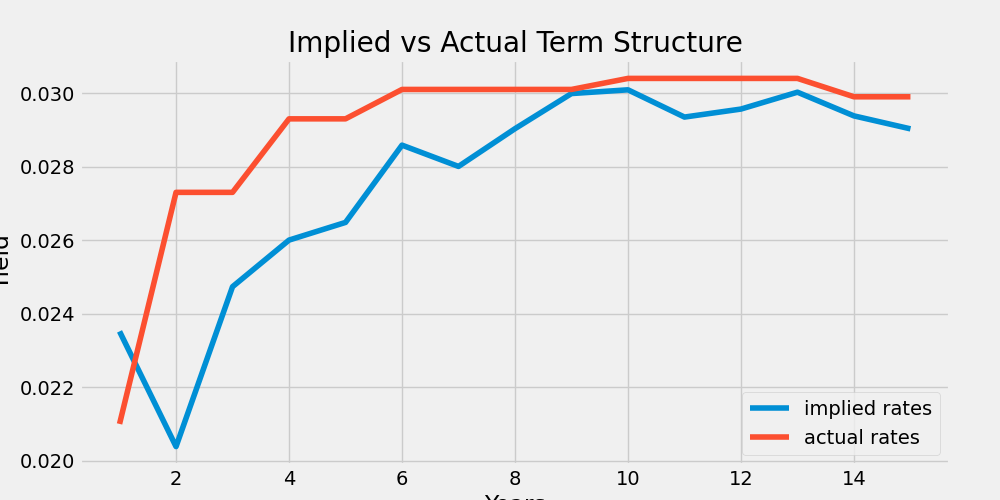

In [44]:
o = [{'name':name, 'shadow price':c.pi}
    for name, c in dedication_1.constraints.items()]
shadow_prices = pd.DataFrame(o, index=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
shadow_prices.drop(columns=['name'],axis= 1, inplace=True)
shadow_prices.index.name = 'Period'
shadow_prices['implied rates'] = [1/shadow_prices['shadow price'][i]**(1/(i/2+0.5))-1 for i in shadow_prices.index.to_list()]
shadow_prices['actual rates'] = rates_for_periods[0:15]

with plt.style.context('fivethirtyeight'):
    fig = plt.subplots(figsize=(10,5))
    plt.plot(shadow_prices['implied rates'], label = 'implied rates')
    plt.plot(shadow_prices['actual rates'], label = 'actual rates')
    plt.title('Implied vs Actual Term Structure')
    plt.ylabel('Yield')
    plt.xlabel('Years')
    plt.legend()

md(''' 
##### <center> Sensitivity & Rates </center>

<center>

{}

'''.format(shadow_prices.to_markdown())
)

# Stopped Here

I have to finish some docstringing and review with you both as well as double checking some calcs.

Clean up/Making Pretty will happen later 